# 化学反应台阶图快速绘制


<a href="https://nb.bohrium.dp.tech/user/update/4934994790" target="_blank"><img src="https://cdn.dp.tech/bohrium/web/static/images/open-in-bohrium.svg" alt="Open In Bohrium"/></a>


<div style="color:black; background-color:#FFF3E9; border: 1px solid #FFE0C3; border-radius: 10px; margin-bottom:0rem">
    <p style="margin:1rem; padding-left: 1rem; line-height: 2.5;">
        ©️ <b><i>Copyright 2023 @ Authors</i></b><br/>
        <i>作者：
            <b>
            <a href="mailto:chensa@dp.tech">陈思安 📨 </a>
            </b>
        </i>
        <br/>
        <i>日期：2023-11-10</i><br/>
        <i>共享协议：</a>本作品采用<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">知识共享署名-非商业性使用-相同方式共享 4.0 国际许可协议</a>进行许可。</i><br/>
        <i>代码说明：</a>本作品代码主要来源于Bohrium平台助手Bohr，部分代码参考自blog文章<a rel="python脚本提取数据绘制电化学台阶图" href="https://jonyafei.github.io/2021/06/20/python%E8%84%9A%E6%9C%AC%E6%8F%90%E5%8F%96%E6%95%B0%E6%8D%AE%E7%BB%98%E5%88%B6%E7%94%B5%E5%8C%96%E5%AD%A6%E5%8F%B0%E9%98%B6%E5%9B%BE/">python脚本提取数据绘制电化学台阶图</a>。</i><br/>
        <i>快速开始：点击上方的</i> <span style="background-color:rgb(85, 91, 228); color:white; padding: 3px; border-radius: 5px;box-shadow: 2px 2px 3px rgba(0, 0, 0, 0.3); font-size:0.75rem;">开始连接</span> <i>按钮，选择 <b><u>bohrium-notebook:2023-04-07</u>镜像</b>，任意配置机型即可开始。<br/>
    </p>
</div>

In [ ]:
a = 24 * 60 * 60;
print(a);

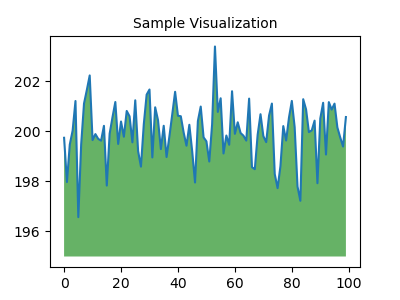

In [1]:
# @title 默认标题文本
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

台阶图广泛出现在涉及化学反应的论文中，通常通过量化/DFT/AIMD等计算获取反应自由能与能垒，对反应自由能、反应路径和反应机理进行直观展示。  
如[文献 J. Am. Chem. Soc., 133 (2011) 20116-20119.](https://pubs.acs.org/doi/10.1021/ja209206c)中，对g-C3N4上的ORR机理进行了计算和分析。

<img src="https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/13375/184c778dd49c494dba8829f0d97ce613/2ONMZFal2wN4HWc0TBUasw.png" style="width:500px">

又如[文献 RSC Advances, 2012, 2, 5439–5446](https://doi.org/10.1039/c2ra20200j)中，对有机分子1,3-propane sultone的得电子还原反应路径进行了系列研究。  
<img src="https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/13375/184c778dd49c494dba8829f0d97ce613/j-BuQP7i_ENQYaxfdGuZCg.png" style="width:500px">
<img src="https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/13375/184c778dd49c494dba8829f0d97ce613/diDnku0xqTzwRPqK7otHpQ.png" style="width:500px">


本notebook旨在实现化学反应台阶图的快速作图。



## 运行环境  
本notebook主要依赖为matplotlib


In [1]:
import copy

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from cycler import cycler
from dataclasses import dataclass, field
from matplotlib.transforms import Bbox
from typing import Union, List, Optional
from pathlib import Path


Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

## 台阶图数据类定义及基本功能   
这里定义了台阶图绘制所需的基本数据类，我们定义了一个名为`StepsGraph`的类，用于绘制折线图。类中包含一个`plot_line_dot`方法，该方法接收一个matplotlib.pyplot.Axes对象，并在其上绘制虚实折线图。它还接受一
些可选参数，如颜色、路径标签、能量标签、步骤标签等。这个方法首先处理输入的数据点，然后在图上绘制虚线和实线折线图。接下来，它会根据指定的设置标记能量值和步骤标签。这个类是用于处理能量值和反应
路径的数据可视化。

In [2]:
@dataclass
class StepsGraph:
    # data: Union[list, np.ndarray]
    data: list
    legend_txt: str = None
    labels: List[str] = None
    
    def __post_init__(self):
        if self.labels:
            if len(self.data) != len(self.labels):
                raise ValueError("The lengths of data and labels must be equal.")
        
    def plot_line_dot(
        self,
        ax: plt.Axes,
        color: Optional[str] = None,
        path_label: str = None,
        energy_label: bool = False, energy_label_fontsize=18,
        step_label: List[str] = None, step_label_fontsize=12,
        # image_label: List[str] = None
    ):
        """绘制虚实折线图"""
        y = copy.deepcopy(self.data)
        y_max, y_min = np.max(y), np.min(y)  # 获取y值的最大值和最小值
        y_bias = (y_max - y_min) / 25  # 获取文本标签y方向偏移量
        x = range(len(y))
        if path_label is None:
            path_label = self.legend_txt
        if step_label is None:
            step_label = self.labels
        # if image_label is None:
        #     image_label = self.images
        # for i in range(len(y)):  # 遍历所有列的能量值
        y_new = []
        x_new = []
        # 1.生成新的XY坐标点，个数加倍
        for j in range(len(y)):
            y_new.append(y[j])
            y_new.append(y[j])
            x_new.append(2*j)
            x_new.append(2*j+1)
        # 2.绘制虚线折线图
        if color is None:
            color = next(ax._get_lines.prop_cycler)['color']
            # print("now color is: ", color)
        ax.plot(x_new, y_new, linestyle='--', linewidth=2, color=color,
                # label=path_label
                )
        
        # 3.绘制实线折线图
        k = 0
        while k < len(y_new):
            x_line = [x_new[k], x_new[k+1]]
            y_line = [y_new[k], y_new[k+1]]
            ax.plot(x_line, y_line, linestyle='-', linewidth=4, color=color, label=path_label if k == 0 else None)
            k += 2
        
        
        # 4.标记能量值，偏移量视具体情况而定
        if energy_label:
            for j in range(len(x)):
                # plt.text(x[j] * 2 - 0.9, y[i][j] + y_bias, "{:.2f}".format(y[i][j]), fontsize=FontSize, color=color[i])    
                ax.text(x[j] * 2 + 0.5 , y[j] + y_bias, "{:.2f}".format(y[j]), fontsize=energy_label_fontsize, color=color, horizontalalignment='center')    
                # ax.text((x[2*j] + x[2*j + 1]) / 2, y[j] + y_bias, "{:.2f}".format(y[j]), fontsize=FontSize, color=color)

        now_minx, now_maxx = ax.get_xlim()
        now_miny, now_maxy = ax.get_ylim()
        if step_label:
            for j in range(len(x)):
                # ax.text(x[j] * 2 + 0.5, y_min - y_bias, step_label[j], fontsize=step_label_fontsize, color=color, horizontalalignment='center', verticalalignment='top')
                ax.text(
                    (x[j] * 2 + 0.5 - now_minx) / (now_maxx - now_minx),
                    0,
                    step_label[j],
                    fontsize=step_label_fontsize,
                    color=color,
                    horizontalalignment='center',
                    verticalalignment='top',
                    transform=ax.transAxes
                )
        ax.set_xticks([])
        ax.set_xticklabels([])

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

### Quickstart与颜色修改  
定义三个不同的“反应路径”，StepsGraph类可自动根据其不同实例适配颜色。

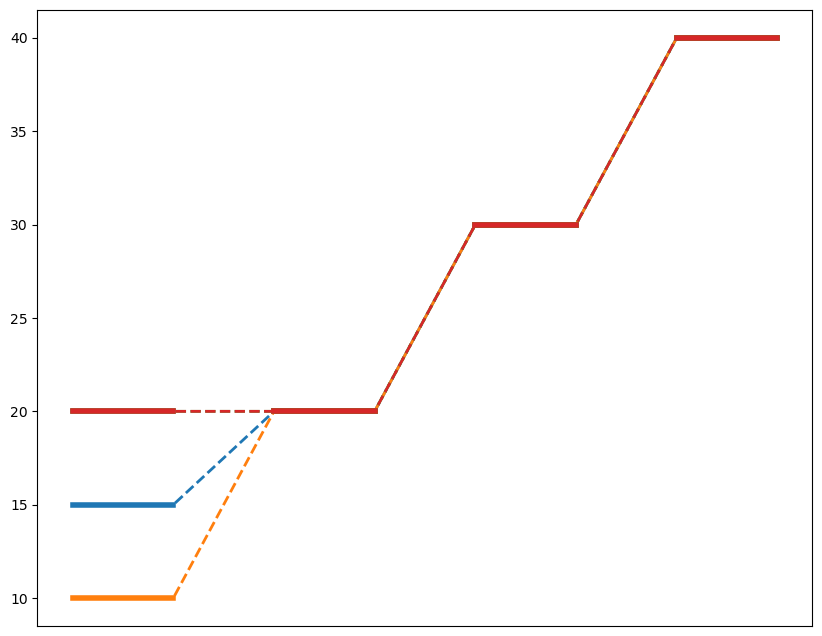

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [3]:
figure = plt.figure(figsize=(10, 8), dpi=100)
ax = figure.add_subplot(111)
stepgraph_ins1 = StepsGraph(data=[15,20,30,40])
stepgraph_ins1.plot_line_dot(ax)
stepgraph_ins2 = StepsGraph(data=[10,20,30,40])

stepgraph_ins2.plot_line_dot(ax)
stepgraph_ins3 = StepsGraph(data=[20,20,30,40])

stepgraph_ins3.plot_line_dot(ax)
stepgraph_ins3.plot_line_dot(ax)

此时所定义的三个数据类如下：

In [4]:
print(stepgraph_ins1)
print(stepgraph_ins2)
print(stepgraph_ins3)

StepsGraph(data=[15, 20, 30, 40], legend_txt=None, labels=None)
StepsGraph(data=[10, 20, 30, 40], legend_txt=None, labels=None)
StepsGraph(data=[20, 20, 30, 40], legend_txt=None, labels=None)


Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

可更改颜色列表为"tab20"，其他matplotlib内置的可选颜色列表包括但不限于：
<br> 
 
<img src="https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/13375/184c778dd49c494dba8829f0d97ce613/g5BAwGLqviOvqo-EtfNYDQ.png" style="width:800px">

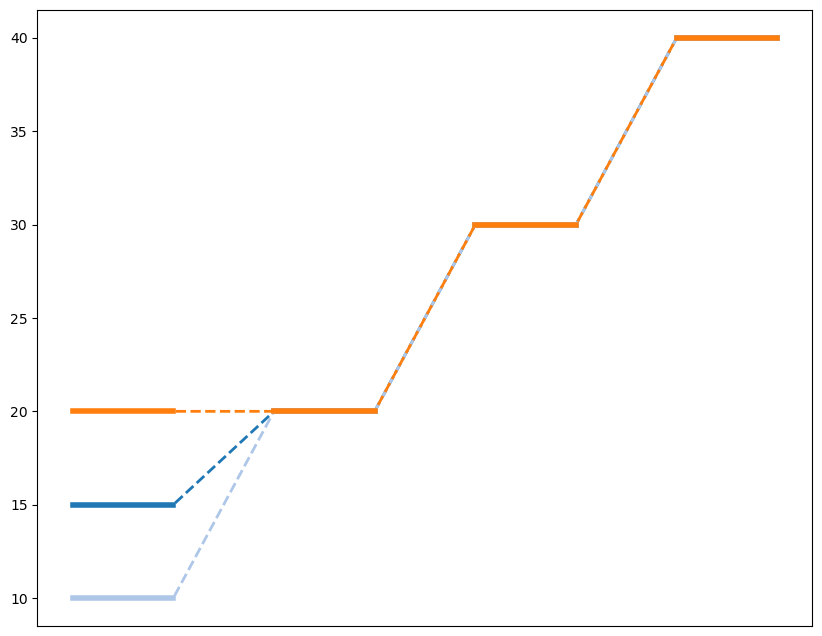

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [5]:
figure = plt.figure(figsize=(10, 8), dpi=100)

ax = figure.add_subplot(111)
cmap = plt.get_cmap('tab20')
ax.set_prop_cycle(cycler('color', cmap.colors))
stepgraph_ins1 = StepsGraph(data=[15,20,30,40])
stepgraph_ins1.plot_line_dot(ax)
stepgraph_ins2 = StepsGraph(data=[10,20,30,40])

stepgraph_ins2.plot_line_dot(ax)
stepgraph_ins3 = StepsGraph(data=[20,20,30,40])

stepgraph_ins3.plot_line_dot(ax)


当然，也可通过实例方法plot_line_dot的关键词参数color进行颜色设置。例如分别将三条曲线设置为"r"、"g"、"b"。（此处是配色反面教材，用于发表请务必不要采用此配色）

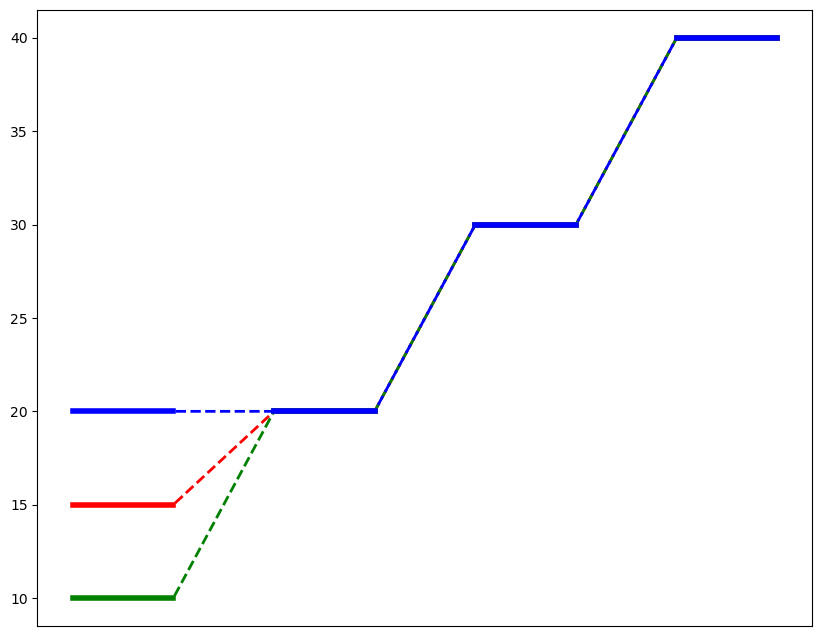

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [6]:
figure = plt.figure(figsize=(10, 8), dpi=100)

ax = figure.add_subplot(111)

stepgraph_ins1 = StepsGraph(data=[15,20,30,40])
stepgraph_ins1.plot_line_dot(ax, color="r")
stepgraph_ins2 = StepsGraph(data=[10,20,30,40])

stepgraph_ins2.plot_line_dot(ax, color="g")
stepgraph_ins3 = StepsGraph(data=[20,20,30,40])

stepgraph_ins3.plot_line_dot(ax, color="b")


### 标签显示(path label)  
可通过定义数据类StepsGraph的legend_txts属性，显示标签。

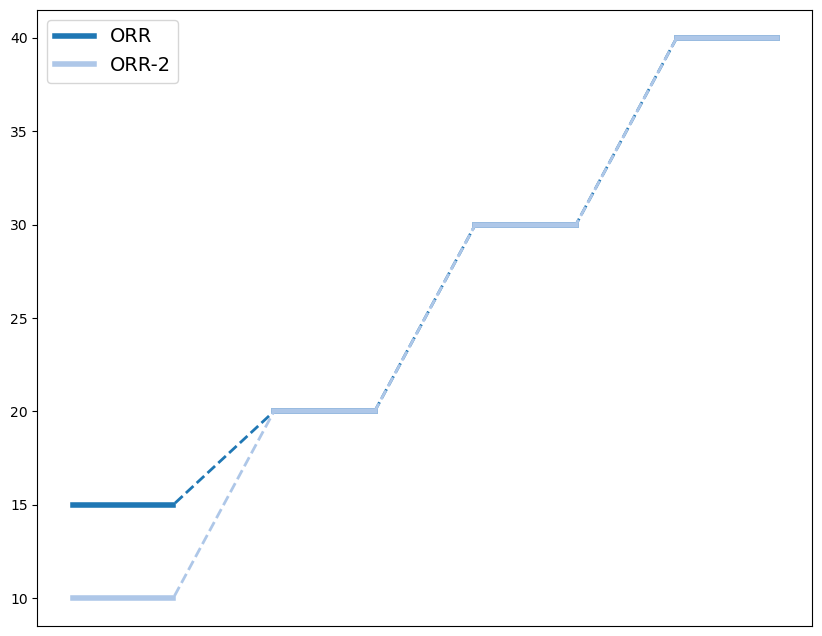

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [7]:
figure = plt.figure(figsize=(10, 8), dpi=100)


ax = figure.add_subplot(111)
cmap = plt.get_cmap('tab20')
ax.set_prop_cycle(cycler('color', cmap.colors))
stepgraph_ins1 = StepsGraph(data=[15,20,30,40], legend_txt="ORR")
stepgraph_ins1.plot_line_dot(ax)
stepgraph_ins2 = StepsGraph(data=[10,20,30,40], legend_txt="ORR-2")

stepgraph_ins2.plot_line_dot(ax)
ax.legend(fontsize=14)

也可通过实例方法plot_line_dot的关键词参数path_label进行标签设置，优先级高于legend_txt

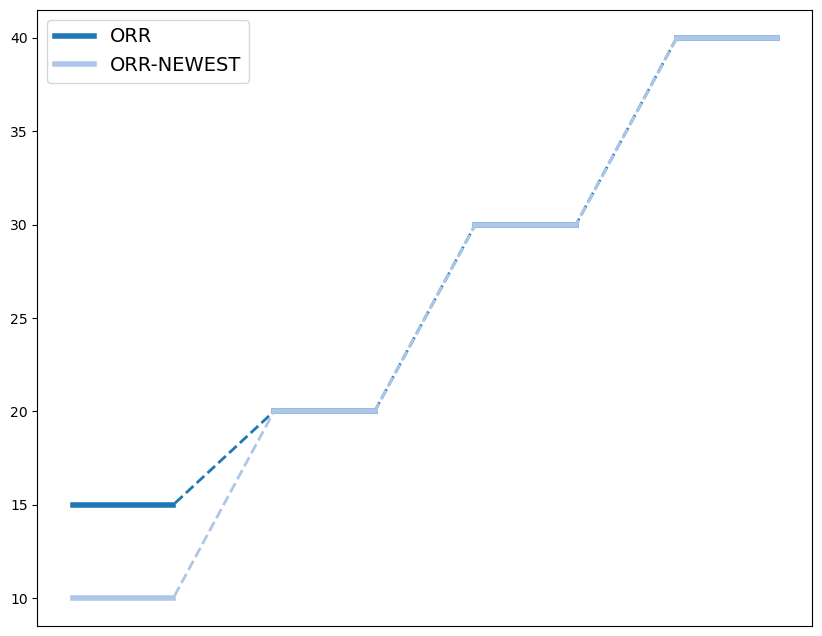

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [19]:
figure = plt.figure(figsize=(10, 8), dpi=100)


ax = figure.add_subplot(111)
cmap = plt.get_cmap('tab20')
ax.set_prop_cycle(cycler('color', cmap.colors))
stepgraph_ins1 = StepsGraph(data=[15,20,30,40], legend_txt="ORR")
stepgraph_ins1.plot_line_dot(ax)
stepgraph_ins2 = StepsGraph(data=[10,20,30,40], legend_txt="ORR-2")

stepgraph_ins2.plot_line_dot(ax, path_label="ORR-NEWEST")
ax.legend(fontsize=14)

### 能量标记(energy label)  
可通过设置实例方法plot_line_dot的关键词参数energy_label=True,直接在图上标记每个台阶对应的能量值

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


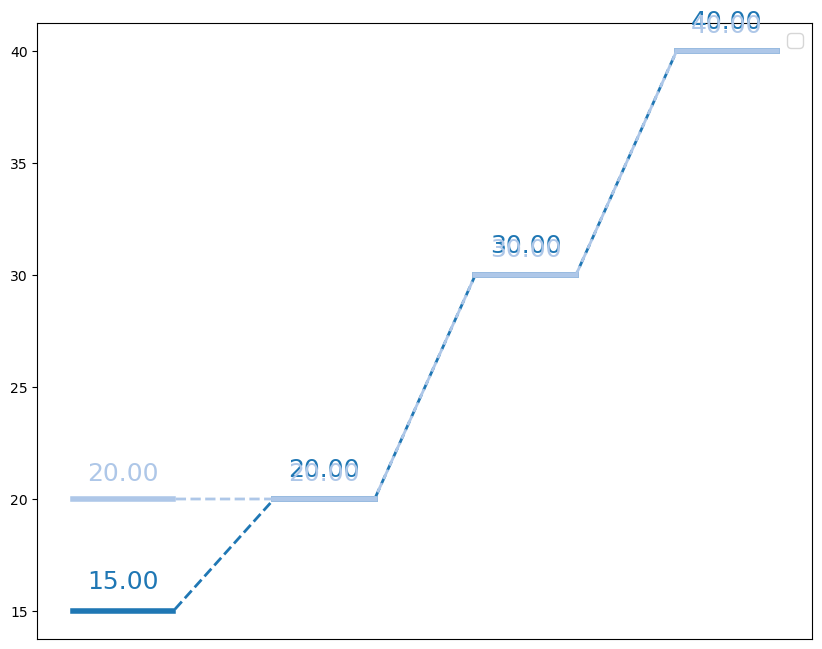

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [22]:
figure = plt.figure(figsize=(10, 8), dpi=100)

ax = figure.add_subplot(111)
cmap = plt.get_cmap('tab20')
ax.set_prop_cycle(cycler('color', cmap.colors))

stepgraph_ins1 = StepsGraph(data=[15,20,30,40])
stepgraph_ins1.plot_line_dot(ax, energy_label=True)

stepgraph_ins2 = StepsGraph(data=[20,20,30,40])
stepgraph_ins2.plot_line_dot(ax, energy_label=True)

# ax.legend(fontsize=14)

### 步骤标记(step label)  
可通过定义数据类StepsGraph的legend_txts属性，显示标签。


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


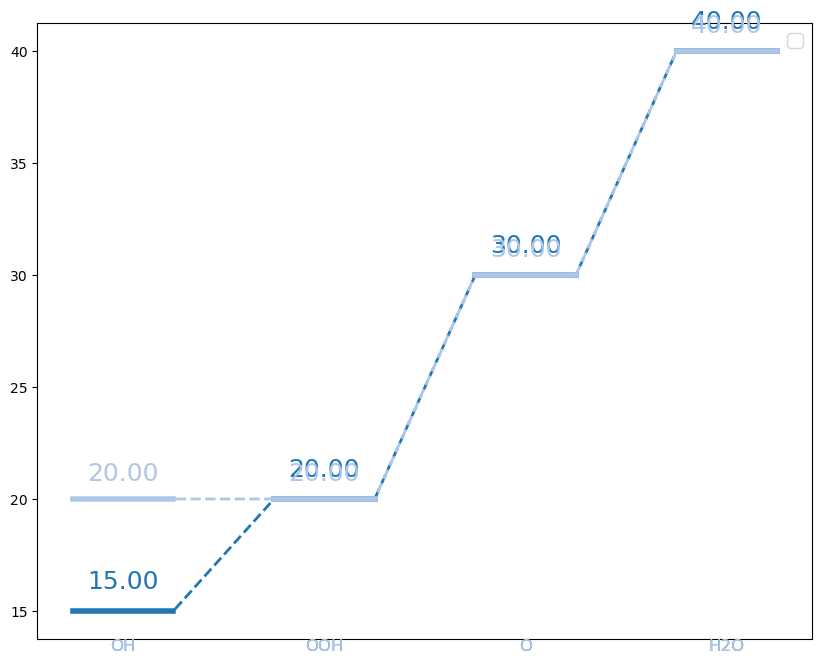

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [10]:
figure = plt.figure(figsize=(10, 8), dpi=100)


ax = figure.add_subplot(111)
cmap = plt.get_cmap('tab20')
ax.set_prop_cycle(cycler('color', cmap.colors))
stepgraph_ins1 = StepsGraph(data=[15,20,30,40], labels=["OH","OOH","O","H2O"])
stepgraph_ins1.plot_line_dot(ax, energy_label=True)

# stepgraph_ins1.plot_line_dot(ax, step_label=["OH","OOH","O","H2O"])
stepgraph_ins2 = StepsGraph(data=[20,20,30,40], labels=["OH","OOH","O","H2O"])

stepgraph_ins2.plot_line_dot(ax, energy_label=True)

# stepgraph_ins2.plot_line_dot(ax, step_label=["OH","OOH","O","H2O"])
# ax.legend(fontsize=14)

可通过设置实例方法plot_line_dot的关键词参数step_label_fontsize,调节步骤标记的大小。

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


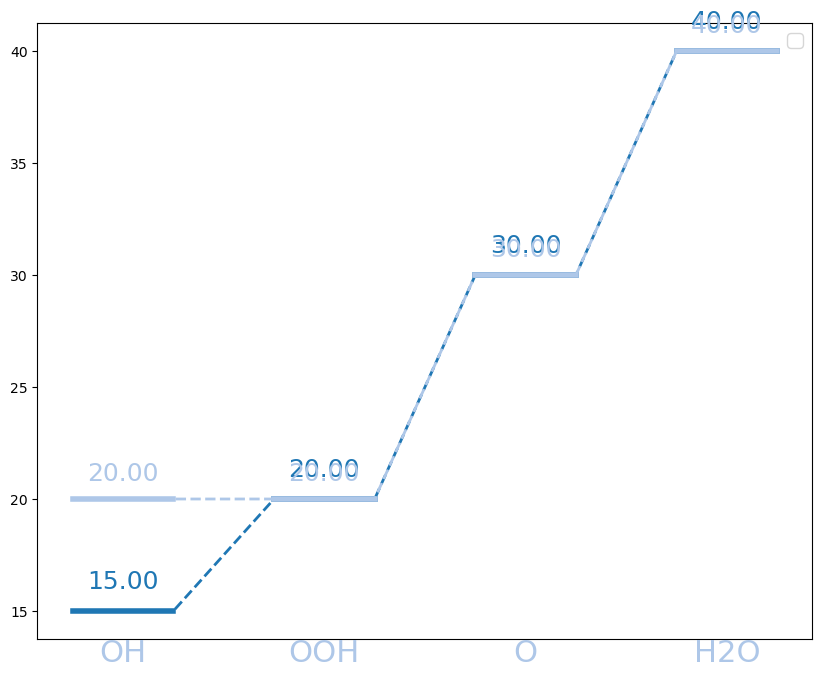

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [11]:
figure = plt.figure(figsize=(10, 8), dpi=100)


ax = figure.add_subplot(111)
cmap = plt.get_cmap('tab20')
ax.set_prop_cycle(cycler('color', cmap.colors))
stepgraph_ins1 = StepsGraph(data=[15,20,30,40], labels=["OH","OOH","O","H2O"])
stepgraph_ins1.plot_line_dot(ax, energy_label=True, step_label=[])

stepgraph_ins2 = StepsGraph(data=[20,20,30,40], labels=["OH","OOH","O","H2O"])

stepgraph_ins2.plot_line_dot(ax, energy_label=True, step_label_fontsize=22)

# stepgraph_ins2.plot_line_dot(ax, step_label=["OH","OOH","O","H2O"])
ax.legend(fontsize=14)

## 绘制文献台阶图  
以开篇展示的[文献 RSC
 Advances, 2012, 2, 5439–5446](https://doi.org/10.1039/c2ra20200j)为例，快速绘制其台阶图，执行如下代码
：

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-120.0, 10.0)

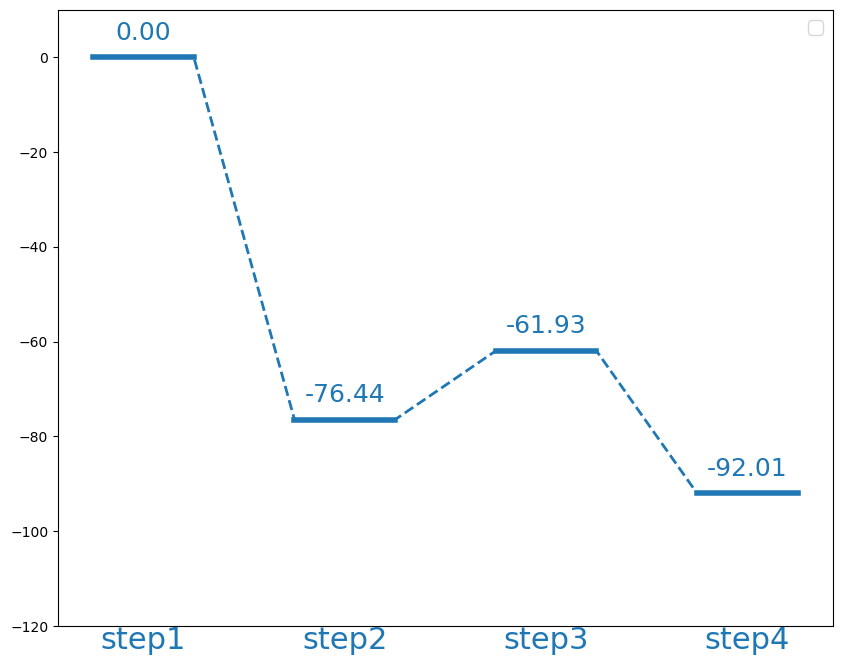

Error: INVALID mime type: status. Must be in the format "type/subtype[;optionalparameter]"

In [12]:
figure = plt.figure(figsize=(10, 8), dpi=100)

ax = figure.add_subplot(111)
cmap = plt.get_cmap('tab20')
ax.set_prop_cycle(cycler('color', cmap.colors))

stepgraph_ins1 = StepsGraph(data=[0.0,-76.44,-61.93,-92.01], labels=["step1","step2","step3","step4"])
stepgraph_ins1.plot_line_dot(ax, energy_label=True, step_label_fontsize=22)
ax.legend(fontsize=14)
ax.set_ylim(-120, 10)

粘贴分子结构后如下图（右图为文献）

<img src="https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/13375/00a9b333e783488db6898262ec7d876f/-QtDMc-bzYHWxKRgKlT29g.png" style="width:500px"><img src="https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/13375/184c778dd49c494dba8829f0d97ce613/j-BuQP7i_ENQYaxfdGuZCg.png" style="width:500px">

